In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import ERFutils
import dask
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import cf_xarray as cfxr
import scipy.signal as signal
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve_triangular

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

import copy
import os

from numpy import linalg as LA

dask.config.set(**{'array.slicing.split_large_chunks': True})

# Load data and diagnose Green's Functions

In [ ]:
model_set = ERFutils.model_set
A = ERFutils.A
ds_out = ERFutils.ds_out

plot = True
savgol = True
save = False

train_id = ['1pctCO2']
output_path = ERFutils.path_to_ERF_outputs

for train in train_id:
    # Load ERF data
    ERF = {}
    ERF_path = f'{output_path}ERF/ERF_{train}_smooth_all_ds.nc4'
    ERF_ds = xr.open_dataset(ERF_path)
    ERF[train] = ERFutils.ds_to_dict(ERF_ds)
    
    # Diagnose Green's Functions
    ds_control, ds_exp, G_ds = ERFutils.create_multimodel_GF_set(ERF, train, model_set, savgol)
    
    # Plot Global Mean Green's Functions (Optional)
    if plot:
        ERFutils.plot_mean_Greens(G_ds, train, overlay = True, save_fig = False)
        
    G_ds2 = G_ds.mean(dim = 'model')
    
    # Save Green's Functions
    if save:
        G_ds.to_netcdf(f'{output_path}G_{train}_ERF_all_ds.nc4')
        G_ds2.to_netcdf(f'{output_path}G_{train}_ERF_mean_ds.nc4')

In [ ]:
model_set = ERFutils.model_set
A = ERFutils.A
ds_out = ERFutils.ds_out

train_id = ['1pctCO2']
output_path = ERFutils.path_to_ERF_outputs

for train in train_id:
    # Load ERF data
    ERF = {}
    ERF_path = f'{output_path}ERF/ERF_{train}_all_ds.nc4'
    ERF_ds = xr.open_dataset(ERF_path)
    ERF[train] = ERFutils.ds_to_dict(ERF_ds)
    
    tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
    tas_ds = xr.open_dataset(tas_path)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for m in model_set:
    ax.plot(ERF[train][m].ERF.values,alpha=0.5,c='gray')
ax.plot(ERFutils.concat_multirun(ERF[train],'model').mean(dim = 'model').ERF.values,c = 'k', linewidth=2)

In [5]:
# function to perform locally weighted linear regression
def local_weighted_regression(x0, X, Y, tau):
    # add bias term
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]
     
    # fit model: normal equations with kernel
    xw = X.T * weights_calculate(x0, X, tau)
    theta = np.linalg.pinv(xw @ X) @ xw @ Y
    # "@" is used to
    # predict value
    return x0 @ theta

def weights_calculate(x0, X, tau):
    return np.exp(np.sum((X - x0) ** 2, axis=1) / (-2 * (tau **2) ))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


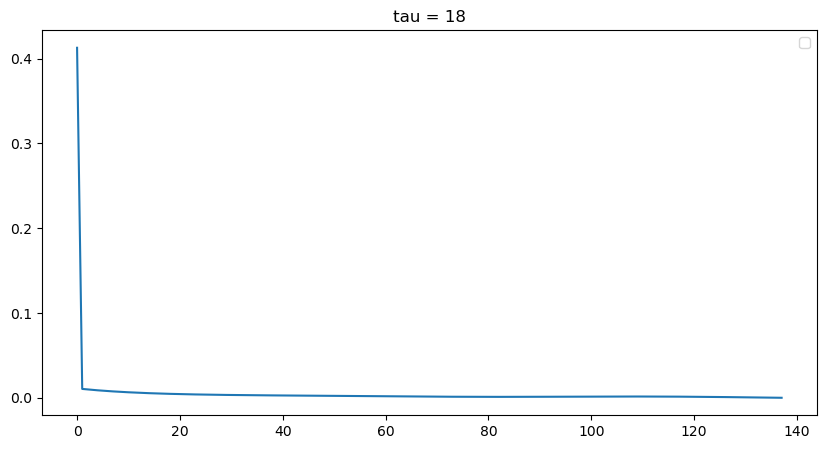

In [31]:
train_id = ['1pctCO2']
output_path = ERFutils.path_to_ERF_outputs
A = ERFutils.A

for train in train_id:
    # Load ERF data
    ERF = {}
    ERF_path = f'{output_path}ERF/ERF_{train}_all_ds.nc4'
    ERF_ds = xr.open_dataset(ERF_path)
    
    #ERF_path_hist = f'{output_path}ERF/ERF_historical_all_ds.nc4'
    #ERF_ssp = xr.open_dataset(ERF_path)
    #ERF_hist = xr.open_dataset(ERF_path_hist)
    #ERF_ds = xr.concat([ERF_hist,ERF_ssp.assign_coords(year = range(165,250))],dim = 'year')
    
    ERF[train] = ERFutils.ds_to_dict(ERF_ds)
    
    tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
    tas_ds = xr.open_dataset(tas_path)
    
ERF_all = ERFutils.concat_multirun(ERF[train],'model').mean(dim = 'model')
tas_glob_mean = tas_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model'])
tas_glob_mean = tas_glob_mean.rename({'s': 'year'})

#if 'ssp' in train:
#    tas_glob_mean = tas_glob_mean.sel(year = slice(165,250)).assign_coords(year = range(0,85))

tas_glob_mean = tas_glob_mean.sel(year = slice(ERF_all['year'].min(), ERF_all['year'].max()))
X1 = ERF_all.year.values
X2 = tas_glob_mean.year.values

tau = 18
j = 12

fig, ax = plt.subplots(figsize=(10,5))
Y1 = ERF_all.ERF.values# - ERF_all.ERF.values[j-1]
Y2 = tas_glob_mean.tas.values# - tas_glob_mean.tas.values[j-1]
N_years = len(ERF_all['year']) - j
offsets = [i for i in range(0,-N_years,-1)]
domain = np.linspace(ERF_all.year.values[j], ERF_all.year.values[-1], num=N_years)

ERF_pred = [local_weighted_regression(x0, X1, Y1, tau) for x0 in domain]
tas_pred = [local_weighted_regression(x0, X2, Y2, tau) for x0 in domain]
input_matrix = diags(ERF_pred,offsets=offsets,shape=(N_years,N_years),format='csr')
array_mat = input_matrix.toarray()
cond_num = LA.cond(array_mat)
#if cond_num > 10000:
#    continue

G = spsolve_triangular(input_matrix,tas_pred,lower=True)
ax.plot(G)
#if any(G[0:20] < 0) or G[0] < G[1]:
#    continue

#conv = signal.convolve(G,ERF_all.ERF.values,'full')
    
ax.set_title(f'tau = {tau}')
ax.legend()

# 1pctCO2 no zero (manual) - tau = 20, j = 4 (0.464)
# 1pctCO2 no zero - tau = 21, j = 2 (0.4105)
# 1pctCO2 zero - tau = 11, j = 4 (0.817)

# ssp126 zero, hist - tau = 15, j = 160
# ssp126 zero, no hist - tau = 5, j = 1

# ssp245 zero, hist - tau = 7, j = 160
# ssp245 zero, no hist - tau = 24, j = 4 

# ssp370 zero, hist - tau = 16, j = 160 (0.0368)
## ssp370 zero, no hist - tau = 8, j = 9 (1.65)
## ssp370 no zero, hist - tau = 5, j = 148 (0.854)
# ssp370 no zero, no hist - tau = 5, j = 0 (0.068)

# ssp585 zero, hist - tau = 14, j = 160
# ssp585 zero, no hist - tau = 20, j = 1

In [ ]:
#tas_g = tas_glob_mean.weighted(A).mean(dim = ['lat','lon']).tas.values
plt.plot(G)
#plt.plot(Y1)#[j:])
#plt.plot(Y2)#[j:])
#plt.plot(ERF_pred)
#plt.plot(tas_pred)

In [ ]:
# Solutions w/ Optimization

# 1pctCO2
## not zero-d, no hist, tau = 21, j = 5

# ssp370
## zero-d, +hist, tau = 24, j = 156 (2.09ish)
## zero-d, no hist, tau = , j = 
## not zero-d, +hist, tau = , j = 
## not zero-d, no hist, tau = , j =

In [22]:
import math
train = '1pctCO2'
tau_range = np.arange(1,25)
j_range = np.arange(0,15)
tau_opt, j_opt, tau_l2_opt, j_l2_opt = gen_opt_G(train, tau_range, j_range, add_hist = False, subtract = False)

Optimizing G for 1pctCO2...
New global optimum found, MAE = 2.0028, tau = 5, j = 9
New global optimum found, L2 = 2.6702, tau = 5, j = 9


In [18]:
def load_G_data(train, add_hist = False):
    A = ERFutils.A
    output_path = ERFutils.path_to_ERF_outputs
    
    # Load tas data
    tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
    tas_ds = (xr.open_dataset(tas_path)).mean(dim = 'model')
    tas_glob_ds = (tas_ds.weighted(A).mean(dim = ['lat','lon'])).rename({'s': 'year'})
    
    # Load ERF data
    ERF_path = f'{output_path}ERF/ERF_{train}_all_ds.nc4'
    if add_hist:
        ERF_path_hist = f'{output_path}ERF/ERF_historical_all_ds.nc4'
        ERF_ssp = xr.open_dataset(ERF_path)
        ERF_hist = xr.open_dataset(ERF_path_hist)
        ERF_ds = xr.concat([ERF_hist,ERF_ssp.assign_coords(year = range(165,250))],dim = 'year')
        
    else:
        ERF_ds = xr.open_dataset(ERF_path)

    ERF_ds = ERFutils.concat_multirun(ERFutils.ds_to_dict(ERF_ds),'model').mean(dim = 'model')
    
    return tas_ds, tas_glob_ds, ERF_ds

In [21]:
def gen_opt_G(train, tau_range, j_range, add_hist = False, subtract = False, verbose = False):
    
    print(f'Optimizing G for {train}...')
    
    # Load required data
    A = ERFutils.A
    tas_ds, tas_glob_ds, ERF_ds = load_G_data(train, add_hist = add_hist)
    tas_ds = tas_ds.sel(s = slice(ERF_ds['year'].min(), ERF_ds['year'].max()))
    tas_glob_ds = tas_glob_ds.sel(year = slice(ERF_ds['year'].min(), ERF_ds['year'].max()))
    X = ERF_ds.year.values
    
    # Used for local GFs, not necessary to recompute
    response_stacked = tas_ds.stack(allpoints=['lat','lon'])
    N_latlong = len(response_stacked.tas.values[0])
    tas_stacked = response_stacked.tas.values
    
    # Generate random indices to evaluate
    n_rand = 1000
    rand_ind = np.random.randint(N_latlong, size=(1, n_rand))
    
    # Instantiate vars
    j_opt, tau_opt, MAE_opt = -1, -1, np.inf
    j_l2_opt, tau_l2_opt, l2_opt = -1, -1, np.inf
    
    # Iterate over smoothing parameters
    for tau in tau_range:
        MAE_loc_opt = np.inf
        for j in j_range:
            if add_hist:
                j += 150

            if subtract:
                Y1 = ERF_ds.ERF.values - ERF_ds.ERF.values[j-1]
                Y2 = tas_glob_ds.tas.values - tas_glob_ds.tas.values[j-1]

            else:
                Y1 = ERF_ds.ERF.values
                Y2 = tas_glob_ds.tas.values
    
            # Smooth data and create ERF matrix
            N_years = len(ERF_ds['year']) - j
            offsets = [i for i in range(0,-N_years,-1)]
            domain = np.linspace(ERF_ds.year.values[j], ERF_ds.year.values[-1], num=N_years)
            
            # Smooth data via local weighted regression
            ERF_smooth = [local_weighted_regression(x0, X, Y1, tau) for x0 in domain]
            tas_glob_smooth = [local_weighted_regression(x0, X, Y2, tau) for x0 in domain]
            ERF_matrix = diags(ERF_smooth,offsets=offsets,shape=(N_years,N_years),format='csr')
    
            # System should be well conditioned for linear solve
            cond_num = LA.cond(ERF_matrix.toarray())
            if cond_num > 10000: continue

            # Calculate global GF to check if this combination is worth evaluating spatially
            G_glob = spsolve_triangular(ERF_matrix,tas_glob_smooth,lower=True)

            # Function should be monotonically decreasing and non-negative
            if G_glob[0] < G_glob[1]: continue
            
            if any(G_glob[0:20] < 0): continue

            # If all constraints are satisfied, continue to local GFs
            G_stacked = np.zeros((N_years,N_latlong))

            ## Evaluate random subset of GFs
            for n in rand_ind:
                if subtract:
                    Y3 = tas_stacked[:,n] - tas_stacked[j-1,n]
                else:
                    Y3 = tas_stacked[:,n]
                tas_loc_smooth = [local_weighted_regression(x0, X, Y3, tau) for x0 in domain]
                G_stacked[:,n] = spsolve_triangular(ERF_matrix,tas_loc_smooth,lower=True)

            ## Create local GF datset
            G_loc = xr.Dataset(coords={'lon': ('lon', tas_ds.lon.values),
                                    'lat': ('lat', tas_ds.lat.values),
                                    's': ('s', range(N_years))})
            G_loc = G_loc.stack(allpoints=['lat','lon'])
            G_loc['G[tas]'] = (('s','allpoints'),G_stacked)
            G_loc = G_loc.unstack('allpoints')
            G_loc['s'] = G_loc['s'] - G_loc['s'][0]
            
            conv_loc = signal.convolve(np.array(G_loc.dropna(dim = 's')['G[tas]']), 
                                       np.array(ERF_ds['ERF'])[~np.isnan(np.array(ERF_ds['ERF']))][..., None, None],
                                       'full')
            conv_loc = ERFutils.np_to_xr(conv_loc, G_loc, ERF_ds)
            
            if add_hist:
                l2_temp = np.mean(vector_norm(tas_ds.tas.values[165:] - conv_loc[165:len(X)],dim=['lat','lon']).weighted(A).mean(dim = ['lat','lon']))
                MAE_temp = np.mean(np.abs(tas_ds.tas.values[165:] - conv_loc[165:len(X)]).weighted(A).mean(dim = ['lat','lon']))
            else:
                l2_temp = math.sqrt(np.square(tas_ds.tas.values - conv_loc[0:len(X)]).weighted(A).mean(dim = ['lat','lon']).mean(dim = ['s']))
                MAE_temp = np.mean(np.abs(tas_ds.tas.values - conv_loc[0:len(X)]).weighted(A).mean(dim = ['lat','lon']))

            if MAE_temp < MAE_opt:
                j_opt, tau_opt, MAE_opt = j, tau, MAE_temp
                print(f'New global optimum found, MAE = {round(float(MAE_opt),4)}, tau = {tau}, j = {j}')
                
            if l2_temp < l2_opt:
                j_l2_opt, tau_l2_opt, l2_opt = j, tau, l2_temp
                print(f'New global optimum found, L2 = {round(float(l2_opt),4)}, tau = {tau}, j = {j}')
            
            if verbose:
                if MAE_temp < MAE_loc_opt:
                    MAE_loc_opt = MAE_temp
                    print(f'\tNew local optimum found, MAE = {round(float(MAE_opt),4)}, tau = {tau}, j = {j}')
    
    return tau_opt, j_opt, tau_l2_opt, j_l2_opt

In [ ]:
train_id = ['ssp370']#,'ssp245','ssp370','ssp585','1pctCO2']
from numpy import linalg as LA
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve
import random

A = ERFutils.A
output_path = ERFutils.path_to_ERF_outputs

for train in train_id:
    # Load ERF data
    ERF = {}
    ERF_path = f'{output_path}ERF/ERF_{train}_all_ds.nc4'
    
    ERF_path_hist = f'{output_path}ERF/ERF_historical_all_ds.nc4'
    ERF_ssp = xr.open_dataset(ERF_path)
    ERF_hist = xr.open_dataset(ERF_path_hist)
    ERF_ds = xr.concat([ERF_hist,ERF_ssp.assign_coords(year = range(165,250))],dim = 'year')
    
    #ERF_ds = xr.open_dataset(ERF_path)
    
    ERF[train] = ERFutils.ds_to_dict(ERF_ds)
    
    tas_path = f'{output_path}tas/tas_CMIP_{train}_all_ds.nc4'
    tas_ds = xr.open_dataset(tas_path)
    
    ERF_all = ERFutils.concat_multirun(ERF[train],'model').mean(dim = 'model')
    tas_all = tas_ds.mean(dim = ['model'])
    #if 'ssp' in train:
    #    tas_all = tas_all.sel(s = slice(165,250)).assign_coords(s = range(0,85))

    tas_all = tas_all.rename({'s': 'year'})    
    tas_all = tas_all.sel(year = slice(ERF_all['year'].min(), ERF_all['year'].max()))
    
    tau = 16
    j = 160
    m = j - 1 

    X1 = ERF_all.year.values
    Y1 = ERF_all.ERF.values - ERF_all.ERF.values[m]

    X2 = tas_all.year.values
    Y2 = tas_all.weighted(A).mean(dim = ['lat','lon']).tas.values - tas_all.weighted(A).mean(dim = ['lat','lon']).tas.values[m]

    N_years = len(ERF_all['year']) - j
    offsets = [i for i in range(0,-N_years,-1)]
    domain = np.linspace(ERF_all.year.values[j], ERF_all.year.values[-1], num=N_years)

    ERF_pred = [local_weighted_regression(x0, X1, Y1, tau) for x0 in domain]
    tas_pred = [local_weighted_regression(x0, X2, Y2, tau) for x0 in domain]

    input_matrix = diags(ERF_pred,offsets=offsets,shape=(N_years,N_years),format='csr')
    G_glob = spsolve_triangular(input_matrix,tas_pred,lower=True)

    array_mat = input_matrix.toarray()
    cond_num = LA.cond(array_mat)
    if cond_num > 10000:
        continue

    print(f'j: {j}, \t Cond: {cond_num}')

    # Have to create the Green's functions locally, stack data array
    stacked_response = tas_all.stack(allpoints=['lat','lon'])
    N_latlong = len(stacked_response.tas.values[0])
    stacked_tas = stacked_response.tas.values

    # Convert to np arrays, xarray indexing is too slow
    G_stacked = np.zeros((N_years,N_latlong))

    # Calculate local Green's functions, matrix is LD by construction
    for k in range(1000): 
        n = random.randint(0,N_latlong)
        Y3 = stacked_tas[:,n] - stacked_tas[m,n]
        stacked_response_local = [local_weighted_regression(x0, X2, Y3, tau) for x0 in domain]
        G_stacked[:,n] = spsolve_triangular(input_matrix,stacked_response_local,lower=True)

    # Get G into the correct format
    G = xr.Dataset(coords={'lon': ('lon', tas_all.lon.values),
                            'lat': ('lat', tas_all.lat.values),
                            'year': ('year', range(N_years))})
    G = G.stack(allpoints=['lat','lon'])
    G['G[tas]'] = (('year','allpoints'),G_stacked)
    G = G.unstack('allpoints')

    G['year'] = G['year'] - G['year'][0]

    G_glob2 = G.weighted(A).mean(dim = ['lat','lon'])['G[tas]']  
    plt.plot(G_glob,label=f'{tau}, {j}')
    plt.plot(G_glob2/G_glob2[0]*G_glob[0])

plt.legend()

# 1pctCO2 no zero (manual) - tau = 20, j = 4 (0.464) *currently in paper, best performing*
# 1pctCO2 no zero - tau = 9, j = 2 (0.4105)
# 1pctCO2 zero - tau = 11, j = 4 (0.817)

# ssp370 zero, hist - tau = 20, j = 156 (0.409)
# ssp370 zero, no hist - tau = 8, j = 9 (1.65)
# ssp370 no zero, hist - tau = 5, j = 148 (0.854) 
# ssp370 no zero, no hist - tau = 5, j = 0 (0.851) *currently in paper (basically)*

In [ ]:
# Have to create the Green's functions locally, stack data array
stacked_response = tas_all.stack(allpoints=['lat','lon'])
N_latlong = len(stacked_response.tas.values[0])
stacked_tas = stacked_response.tas.values

# Convert to np arrays, xarray indexing is too slow
G_stacked = np.zeros((N_years,N_latlong))

# Calculate local Green's functions, matrix is LD by construction
for n in range(N_latlong):
    if n % 5000 == 0:
        print(n)
    Y3 = stacked_tas[:,n] - stacked_tas[m,n]
    stacked_response_local = [local_weighted_regression(x0, X2, Y3, tau) for x0 in domain]
    G_stacked[:,n] = spsolve_triangular(input_matrix,stacked_response_local,lower=True)

# Get G into the correct format
G = xr.Dataset(coords={'lon': ('lon', tas_all.lon.values),
                        'lat': ('lat', tas_all.lat.values),
                        'year': ('year', range(N_years))})
G = G.stack(allpoints=['lat','lon'])
G['G[tas]'] = (('year','allpoints'),G_stacked)
G = G.unstack('allpoints')

G['year'] = G['year'] - G['year'][0]

G.to_netcdf(f'{output_path}GFs/G_loess_h_z_{train}_ERF_mean_ds.nc4')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(G_glob)
plt.plot(G.weighted(A).mean(dim = ['lat','lon'])['G[tas]'])